# Issue #2.1 - Train and test a classification model

## Content

- [Overview](#overview)
- [Exploratory Data Analysis](#eda)
    * [Preview and Pre-processing](#pp)
    * [Univariate Exploration](#ue)
    * [Bivariate Exploration](#be)
- [Models Implementation & Metrics Evaluation](#mime)
    * [Data Preparaion](#dp)
    * [Model Selection](#ms)
        * [K Nearest Neighbors(KNN) Model](#knn)
        * [Logistic Repression Model](#lg)
- [Observations](#ob)
- [Further Improvements](#fi)

<a id='overview'></a>
## Overview
Mozilla is planning to invest more substantially in privacy-preserving machine learning models for applications such as recommending personalized content and detecting malicious behaviour. As such solutions move towards production, it is essential for us to have confidence in the selection of the model and its parameters for a particular dataset, as well as an accurate view into how it will perform in new instances or as the training data evolves.

While the literature contains a broad array of models, evaluation techniques, and metrics, their choice in practice is often guided by convention or convenience, and their sensitivity to different datasets is not always well-understood. Additionally, to our knowledge there is no existing software tool that provides a comprehensive report on the performance of a given model under consideration.

The eventual goal of this project is to build a standard set of tools that Mozilla can use to evaluate the performance of machine learning models in various contexts on the basis of the following principles:

* Holistic view of model performance
  - Eg. evaluating a model in terms of multiple metrics (ie as a battery of tests), and understanding the tradeoffs between them
  * For classification, separating predicted class membership scores from the decision rule assigning a final class
* Stability of performance metrics as an additional metric to optimize for
  * Eg. the variability of performance metrics across difference splits of the dataset
* Generalizability of the model to unseen data
* Explainability/parsimony when possible
* Reproducibility of results
  * Eg. looking for ways to leverage existing public datasets in the evaluation process when the actual data cannot be made public
* Informative failures
  * We can learn a lot by studying the cases where the model performs poorly, eg. misclassifications or cases near the decision boundary
  * Failures may have implications for generalizability, appropriateness of the choice of model, ethical considerations/bias
  * Eg. do we see systematic failures with a homogeneous distribution within themselves but differing from training data.
At this early stage, the focus is on implementing evaluation methodologies in line with these principles, and testing them out across different models and datasets.

<a id='eda'></a>
## Exploratory Data Analysis

**Importing libraries**

In [1]:
# Basic Computations
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import timeit

# Ml Models
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Dynamic Markdowns
from IPython.display import Markdown as md

In [2]:
#**Adding module’s sub-directory to Pythons path**
import os
import sys
sys.path.insert(0, os.path.abspath('../elie_wanko/modules'))
import helpers, knn, logreg

<a id='pp'></a>
### Preview and Pre-processing
**Attributes Information:**

This research employes a binary variable, **C24: default payment (Yes = 1, No = 0)**, as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
* **C1: Amount of the given credit** (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* **C2: Gender** (1 = male; 2 = female).
* **C3: Education** (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* **C4: Marital status** (1 = married; 2 = single; 3 = others).
* **C5: Age** (year).
* **C6 - C11: History of past payment**. We tracked the past monthly payment records (from April to September, 2005) as follows: 
  * **C6** = the repayment status in September, 2005; 
  * **C7** = the repayment status in August, 2005; 
  * . . .;
  * **C11** = the repayment status in April, 2005. 
  
  >_The measurement scale for the repayment status is:_ 
  * _1 = pay duly;_
  * _1 = payment delay for one month;_
  * _2 = payment delay for two months;_
  * _. . .;_
  * _8 = payment delay for eight months;_ 
  * _9 = payment delay for nine months and above._
* **C12 - C17: Amount of bill statement** (NT dollar). 
  * **C12** = amount of bill statement in September, 2005; 
  * **C13** = amount of bill statement in August, 2005; 
  * _. . .;_ 
  * **C17** = amount of bill statement in April, 2005.
* **C18 - C23: Amount of previous payment** (NT dollar). 
  * **C18** = amount paid in September, 2005; 
  * **C19** = amount paid in August, 2005; 
  * _. . .;_
  * **C23** = amount paid in April, 2005.

**Data Preview**

There are 30,000 rows, all Non-Null and 25 columns in our DataFrame, all of which are of numerical data(int64). The sample table below shows the first 5 columns of our data set and the next shows some basic information of every column (*'column Index', 'column_name', 'Non_Null Counts in each column' and 'data type'*).

In [3]:
df_data = pd.read_csv("../../datasets/defaults.csv")
df_data

id  limit_bal  sex  education  marriage  age  pay_0  pay_2  pay_3  \
0          1      20000    2          2         1   24      2      2     -1   
1          2     120000    2          2         2   26     -1      2      0   
2          3      90000    2          2         2   34      0      0      0   
3          4      50000    2          2         1   37      0      0      0   
4          5      50000    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996     220000    1          3         1   39      0      0      0   
29996  29997     150000    1          3         2   43     -1     -1     -1   
29997  29998      30000    1          2         2   37      4      3      2   
29998  29999      80000    1          3         1   41      1     -1      0   
29999  30000      50000    1          2         1   46      0      0      0   

       pay_4  ...  bill_amt4  bill_amt5  bill_amt6  pay_amt1  pay_amt2  \
0         -1  ...          0          0          0         0       689   
1          0  ...       3272       3455       3261         0      1000   
2          0  ...      14331      14948      15549      1518      1500   
3          0  ...      28314      28959      29547      2000      2019   
4          0  ...      20940      19146      19131      2000     36681   
...      ...  ...        ...        ...        ...       ...       ...   
29995      0  ...      88004      31237      15980      8500     20000   
29996     -1  ...       8979       5190          0      1837      3526   
29997     -1  ...      20878      20582      19357         0         0   
29998      0  ...      52774      11855      48944     85900      3409   
29999      0  ...      36535      32428      15313      2078      1800   

       pay_amt3  pay_amt4  pay_amt5  pay_amt6  defaulted  
0             0         0         0         0          1  
1          1000      1000         0      2000          1  
2          1000      1000      1000      5000          0  
3          1200      1100      1069      1000          0  
4         10000      9000       689       679          0  
...         ...       ...       ...       ...        ...  
29995      5003      3047      5000      1000          0  
29996      8998       129         0         0          0  
29997     22000      4200      2000      3100          1  
29998      1178      1926     52964      1804          1  
29999      1430      1000      1000      1000          1  

[30000 rows x 25 columns]

In [4]:
df_data.describe()

id       limit_bal           sex     education      marriage  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                age         pay_0         pay_2         pay_3         pay_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.217904      1.123802      1.197186      1.196868      1.169139   
min       21.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       28.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%       34.000000      0.000000      0.000000      0.000000      0.000000   
75%       41.000000      0.000000      0.000000      0.000000      0.000000   
max       79.000000      8.000000      8.000000      8.000000      8.000000   

       ...      bill_amt4      bill_amt5      bill_amt6       pay_amt1  \
count  ...   30000.000000   30000.000000   30000.000000   30000.000000   
mean   ...   43262.948967   40311.400967   38871.760400    5663.580500   
std    ...   64332.856134   60797.155770   59554.107537   16563.280354   
min    ... -170000.000000  -81334.000000 -339603.000000       0.000000   
25%    ...    2326.750000    1763.000000    1256.000000    1000.000000   
50%    ...   19052.000000   18104.500000   17071.000000    2100.000000   
75%    ...   54506.000000   50190.500000   49198.250000    5006.000000   
max    ...  891586.000000  927171.000000  961664.000000  873552.000000   

           pay_amt2      pay_amt3       pay_amt4       pay_amt5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            pay_amt6     defaulted  
count   30000.000000  30000.000000  
mean     5215.502567      0.221200  
std     17777.465775      0.415062  
min         0.000000      0.000000  
25%       117.750000      0.000000  
50%      1500.000000      0.000000  
75%      4000.000000      0.000000  
max    528666.000000      1.000000  

[8 rows x 25 columns]

In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         30000 non-null  int64
 1   limit_bal  30000 non-null  int64
 2   sex        30000 non-null  int64
 3   education  30000 non-null  int64
 4   marriage   30000 non-null  int64
 5   age        30000 non-null  int64
 6   pay_0      30000 non-null  int64
 7   pay_2      30000 non-null  int64
 8   pay_3      30000 non-null  int64
 9   pay_4      30000 non-null  int64
 10  pay_5      30000 non-null  int64
 11  pay_6      30000 non-null  int64
 12  bill_amt1  30000 non-null  int64
 13  bill_amt2  30000 non-null  int64
 14  bill_amt3  30000 non-null  int64
 15  bill_amt4  30000 non-null  int64
 16  bill_amt5  30000 non-null  int64
 17  bill_amt6  30000 non-null  int64
 18  pay_amt1   30000 non-null  int64
 19  pay_amt2   30000 non-null  int64
 20  pay_amt3   30000 non-null  int64
 21  pay_amt4   3

**Data Cleaning**

* The first column(C1) reprensents the client id number and it has no use in determining whether a client will default or not. For this reason, we will drop this column.
* To keep the naming consistent across "History of past payment (C6-C11)", "Amount of bill statement (C12-C17)" and "Amount of previous payment (C18-C23)", we rename C6 from pay_0 to pay_1. This helps facilitate the identifying months especially during plotting graphs.

In [6]:
# Drop column 'id'
df_data = df_data.drop(columns='id')
# Rename C6 from pay_0 to pay_1 for consistency
df_data = df_data.rename(columns={"pay_0": "pay_1"})

* Other cleaning can be done but without more information we will stop here and save our data to be used in further analysis.

In [7]:
df_data.to_csv("defaults_data.csv", index=False)

**Observations:**

The main feature of data set is **"C24: defaulted"**, this tells us whether a customer defaulted or not. Our variables C1 to C23 will help us support our investigation into the feature of interest above. Some basic statistical details and questions we can pose include:
* A mean value of 1.6 for 'sex' indicates that there are more females than men. Does this mean than women are more prone the default than men?
* Similarly, the mean value of 1.85  for 'education' indicates that most clients are either in graduate school or university. With a value close to 2, we can assume that most of them are in university. The mean value of 35.49years for age, tends to confirm this hypothesis. Question is to shich age group do banks now need to give credits more?
* Last but not the least, the mean value of 'defaulted' column indicates that about 22.12% of clients defaulted.

Next, we further investigate using various distributions to discover more insights and find out if our assumptions are true.

In [8]:
df_data.describe()

limit_bal           sex     education      marriage           age  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667      1.603733      1.853133      1.551867     35.485500   
std     129747.661567      0.489129      0.790349      0.521970      9.217904   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              pay_1         pay_2         pay_3         pay_4         pay_5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.016700     -0.133767     -0.166200     -0.220667     -0.266200   
std        1.123802      1.197186      1.196868      1.169139      1.133187   
min       -2.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        8.000000      8.000000      8.000000      8.000000      8.000000   

       ...      bill_amt4      bill_amt5      bill_amt6       pay_amt1  \
count  ...   30000.000000   30000.000000   30000.000000   30000.000000   
mean   ...   43262.948967   40311.400967   38871.760400    5663.580500   
std    ...   64332.856134   60797.155770   59554.107537   16563.280354   
min    ... -170000.000000  -81334.000000 -339603.000000       0.000000   
25%    ...    2326.750000    1763.000000    1256.000000    1000.000000   
50%    ...   19052.000000   18104.500000   17071.000000    2100.000000   
75%    ...   54506.000000   50190.500000   49198.250000    5006.000000   
max    ...  891586.000000  927171.000000  961664.000000  873552.000000   

           pay_amt2      pay_amt3       pay_amt4       pay_amt5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            pay_amt6     defaulted  
count   30000.000000  30000.000000  
mean     5215.502567      0.221200  
std     17777.465775      0.415062  
min         0.000000      0.000000  
25%       117.750000      0.000000  
50%      1500.000000      0.000000  
75%      4000.000000      0.000000  
max    528666.000000      1.000000  

[8 rows x 24 columns]

<a id='ue'></a>
### Univariate Exploration

In this section, we investigate distributions of individual variables. We note any unusual points or outliers, clean things up and prepare to look at relationships between variables.

#### 1. Genders

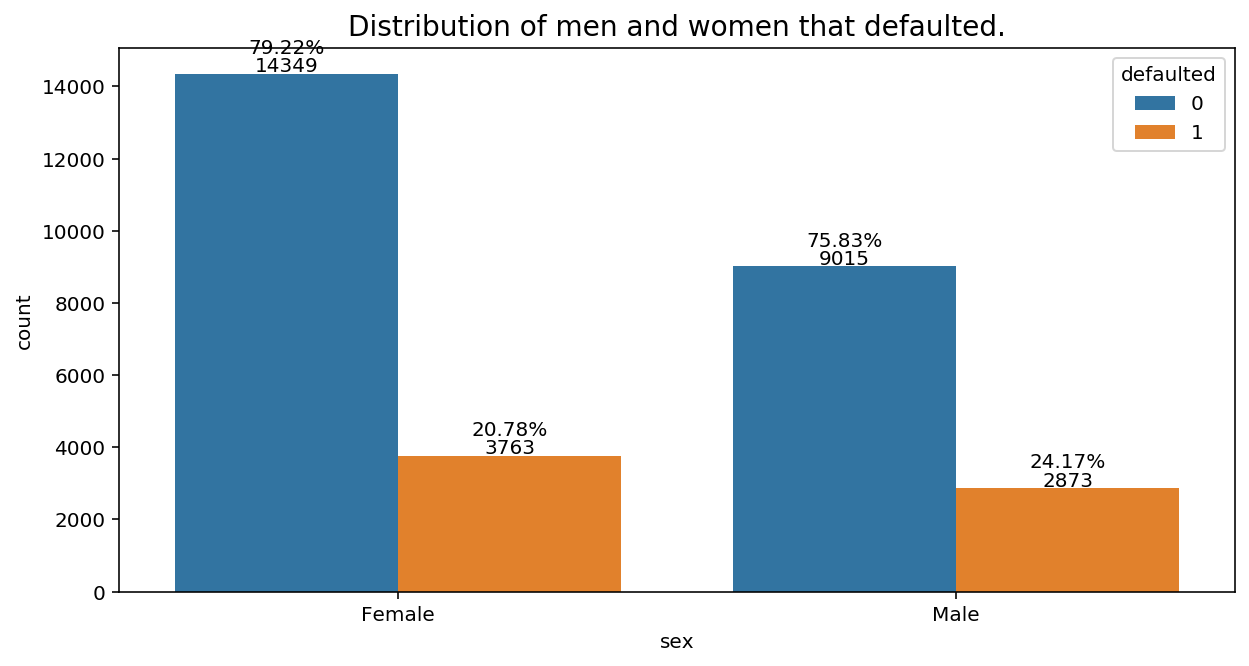

In [9]:
helpers.univ_bar(data=df_data, column='sex', x_title='sex', hue='defaulted', 
                 var_names=['Male', 'Female'], title="Distribution of men and women that defaulted.")

**(1 = male; 2 = female)**

> We can clearly see that women are more at risk to default than men. Despite this fact, the ratio of defaulters in each category is about 7.8:2.2. We will need to investigate further to find the reasons behind this.

#### 2. Marital status

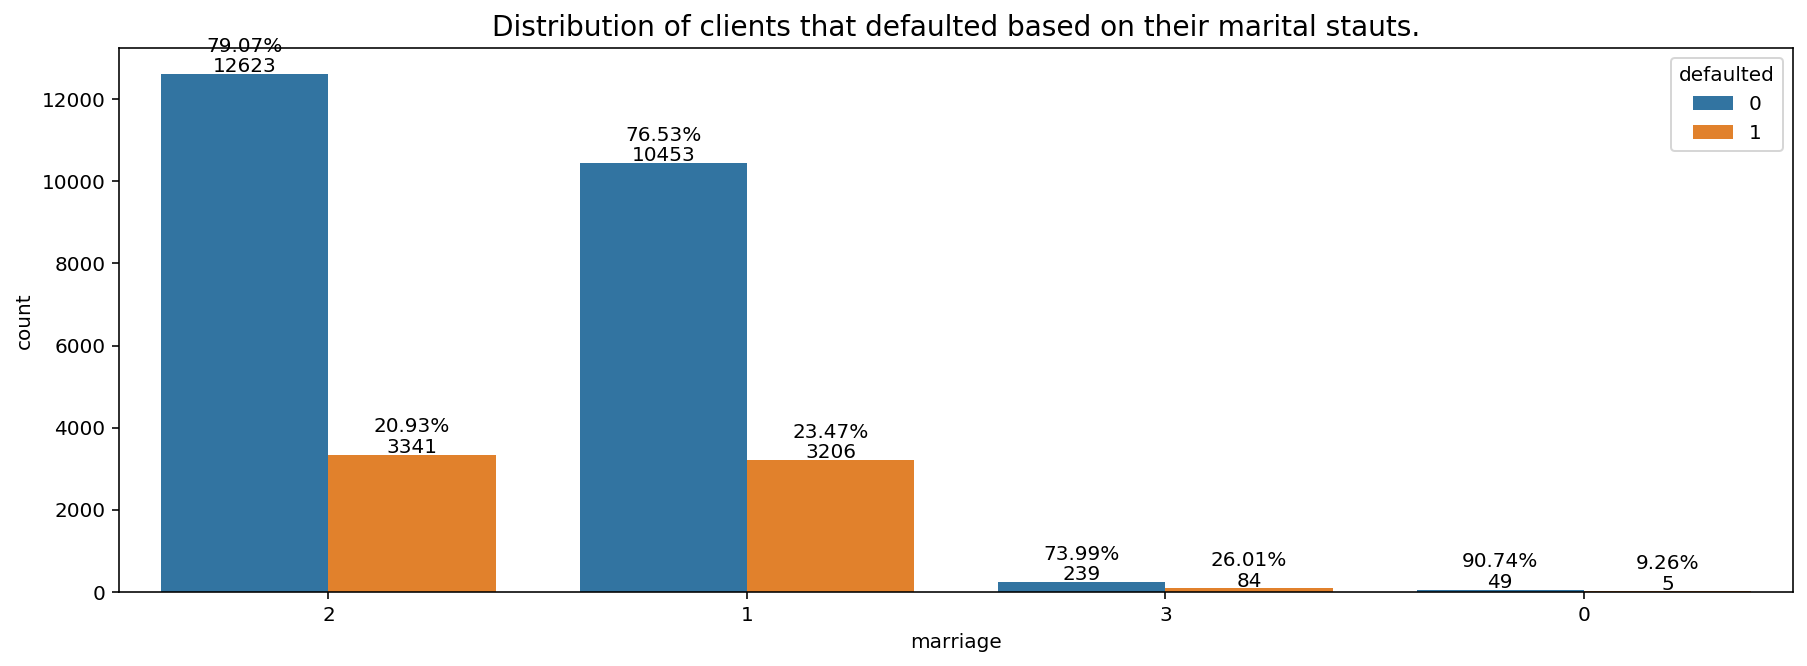

In [10]:
helpers.univ_bar(data=df_data, column='marriage', x_title='marriage', hue='defaulted', fig_w=15, 

                 title="Distribution of clients that defaulted based on their marital stauts.")

**(1 = married; 2 = single; 3 = others)**

> From the plot, clients that are single e are more at risk of defaulting. Though this is closely followed by married clients, we could assume that this difference is because they support each other financially on the long run.

#### 3. Education Level

posx and posy should be finite values
posx and posy should be finite values


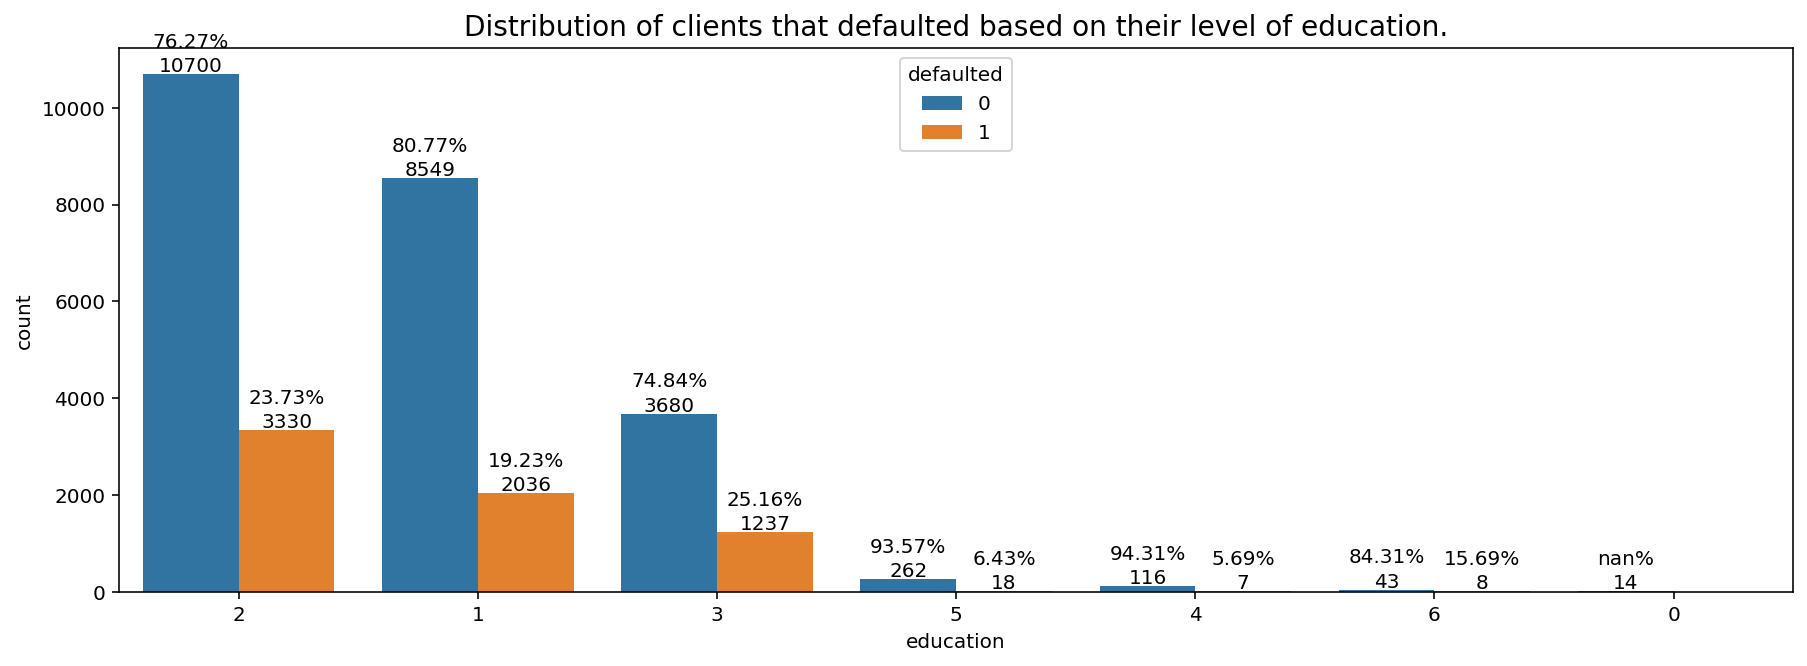

In [11]:
helpers.univ_bar(data=df_data, column='education', x_title='education', hue='defaulted', fig_w=15,
                 title="Distribution of clients that defaulted based on their level of education.")

**(1 = graduate school; 2 = university; 3 = high school; 4 = others)**
> Our graph shows that clients in university, closely followed by thos is graduate school are more likely to default. This is cloud be caused accumalated loan payments to pay school fees.

#### 4. Age Group

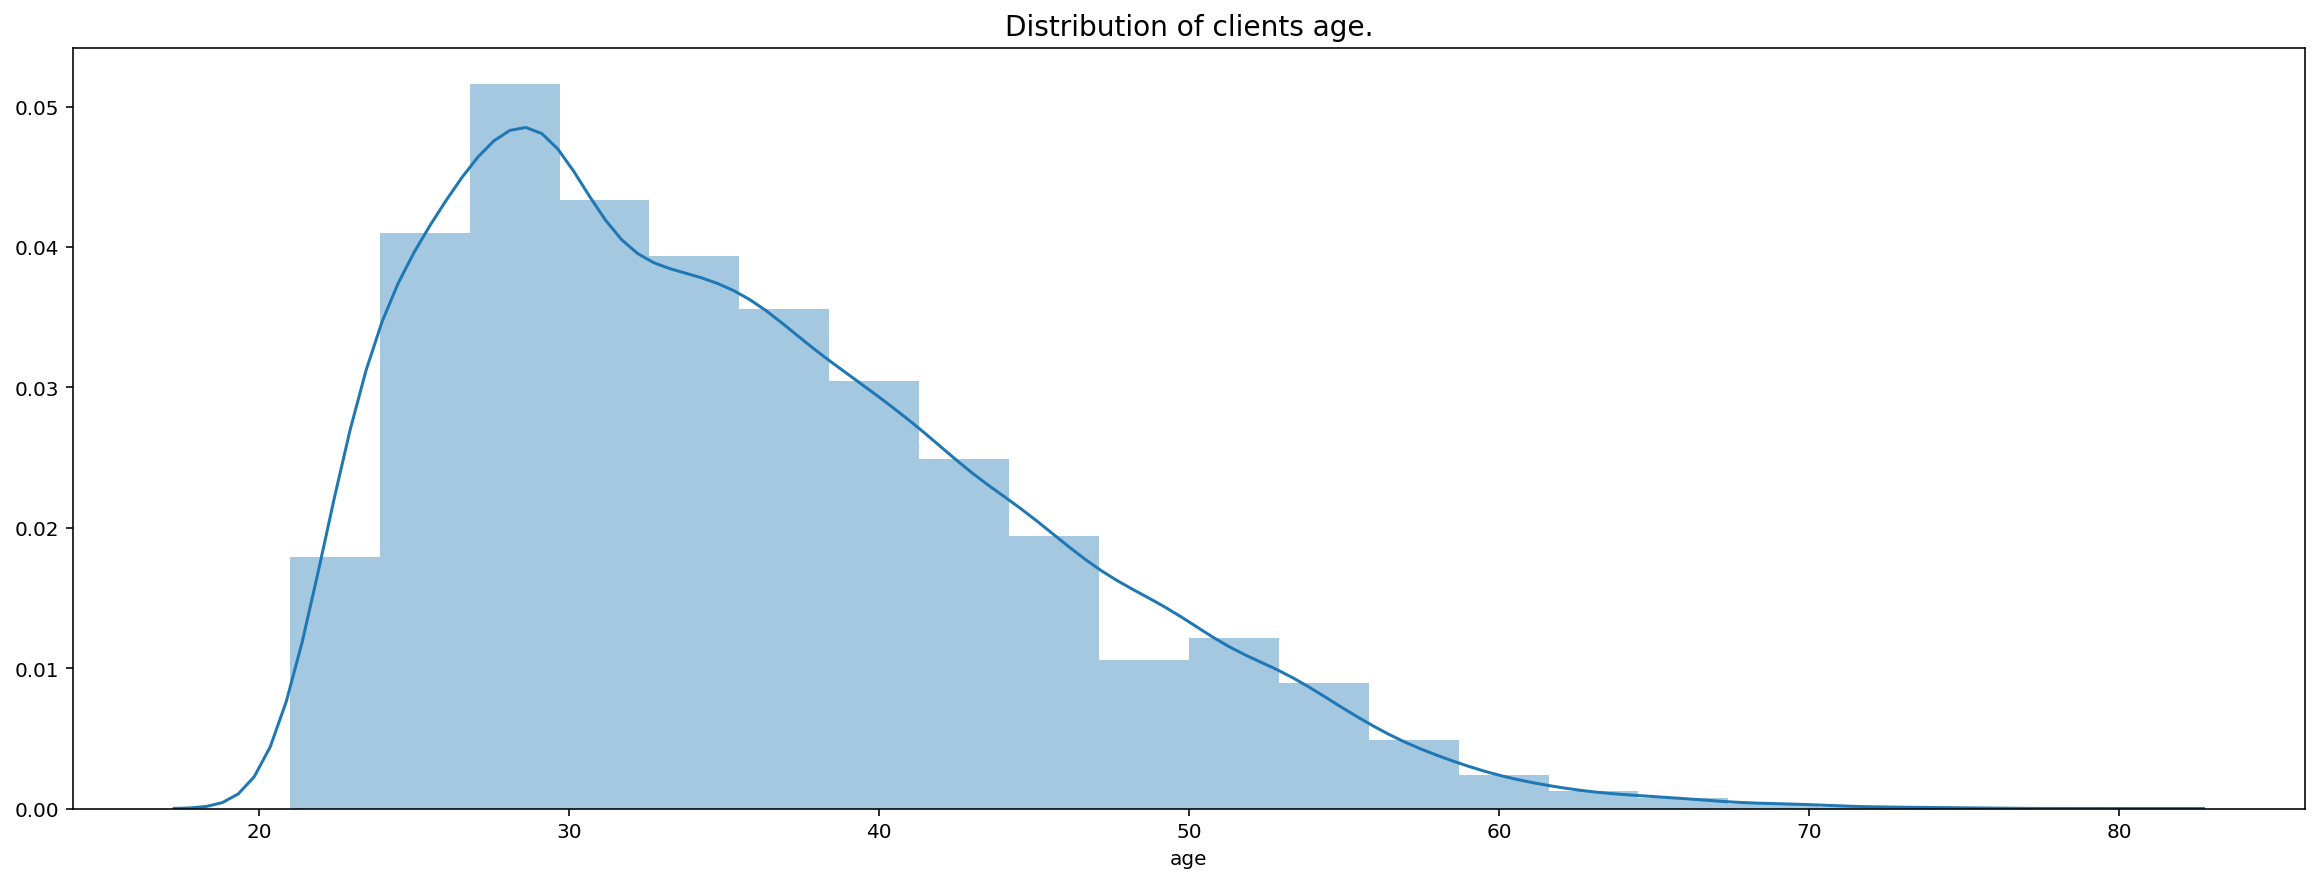

In [12]:
helpers.univ_hist(data=df_data, column='age', fig_w=20, bins=20, title="Distribution of clients age.")

> With a rigt skewed distribution, we can see that most clients in their late 20s and early 30s are more at risk to default, which makes sense as this was similarly observed in the previous graph depicting the default rate per level of education.

#### 5. Account Balance

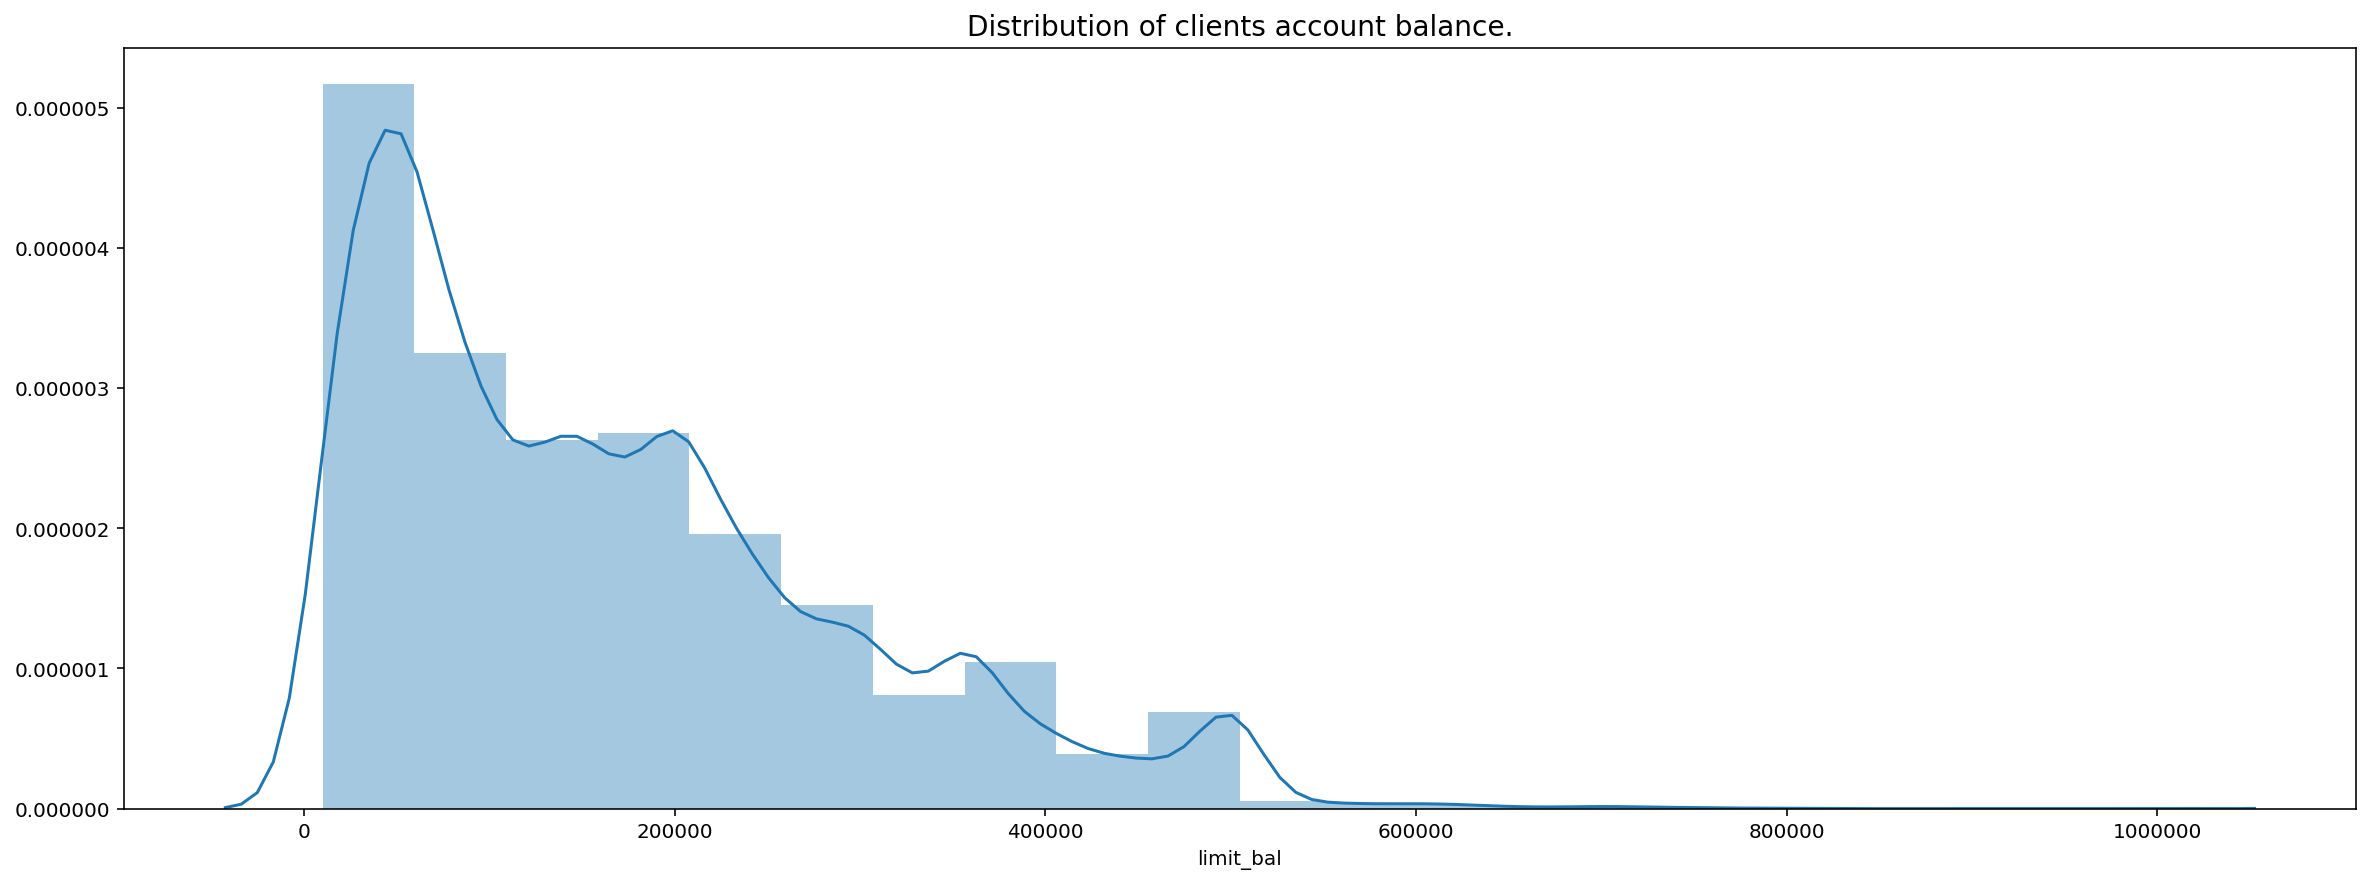

In [13]:
helpers.univ_hist(data=df_data, column='limit_bal', fig_w=20, bins=20, title="Distribution of clients account balance.")

> Here the graph depics that most of our clients are defaulters. However, we are limited quite limited to whom exactly they are and why they defaulted. To further investigated to the reasons behind this we will explore a few bivarte distribution.

<a id='be'></a>
### Bivariate Exploration

In this section, we investigate relationships between pairs of major variables **("limit_bal", "sex", "education", "marriage", "age")** and the financial status **("pay_1", "bill_amt1", "pay_amt1")** of clients accounts in the month of September in our data. 

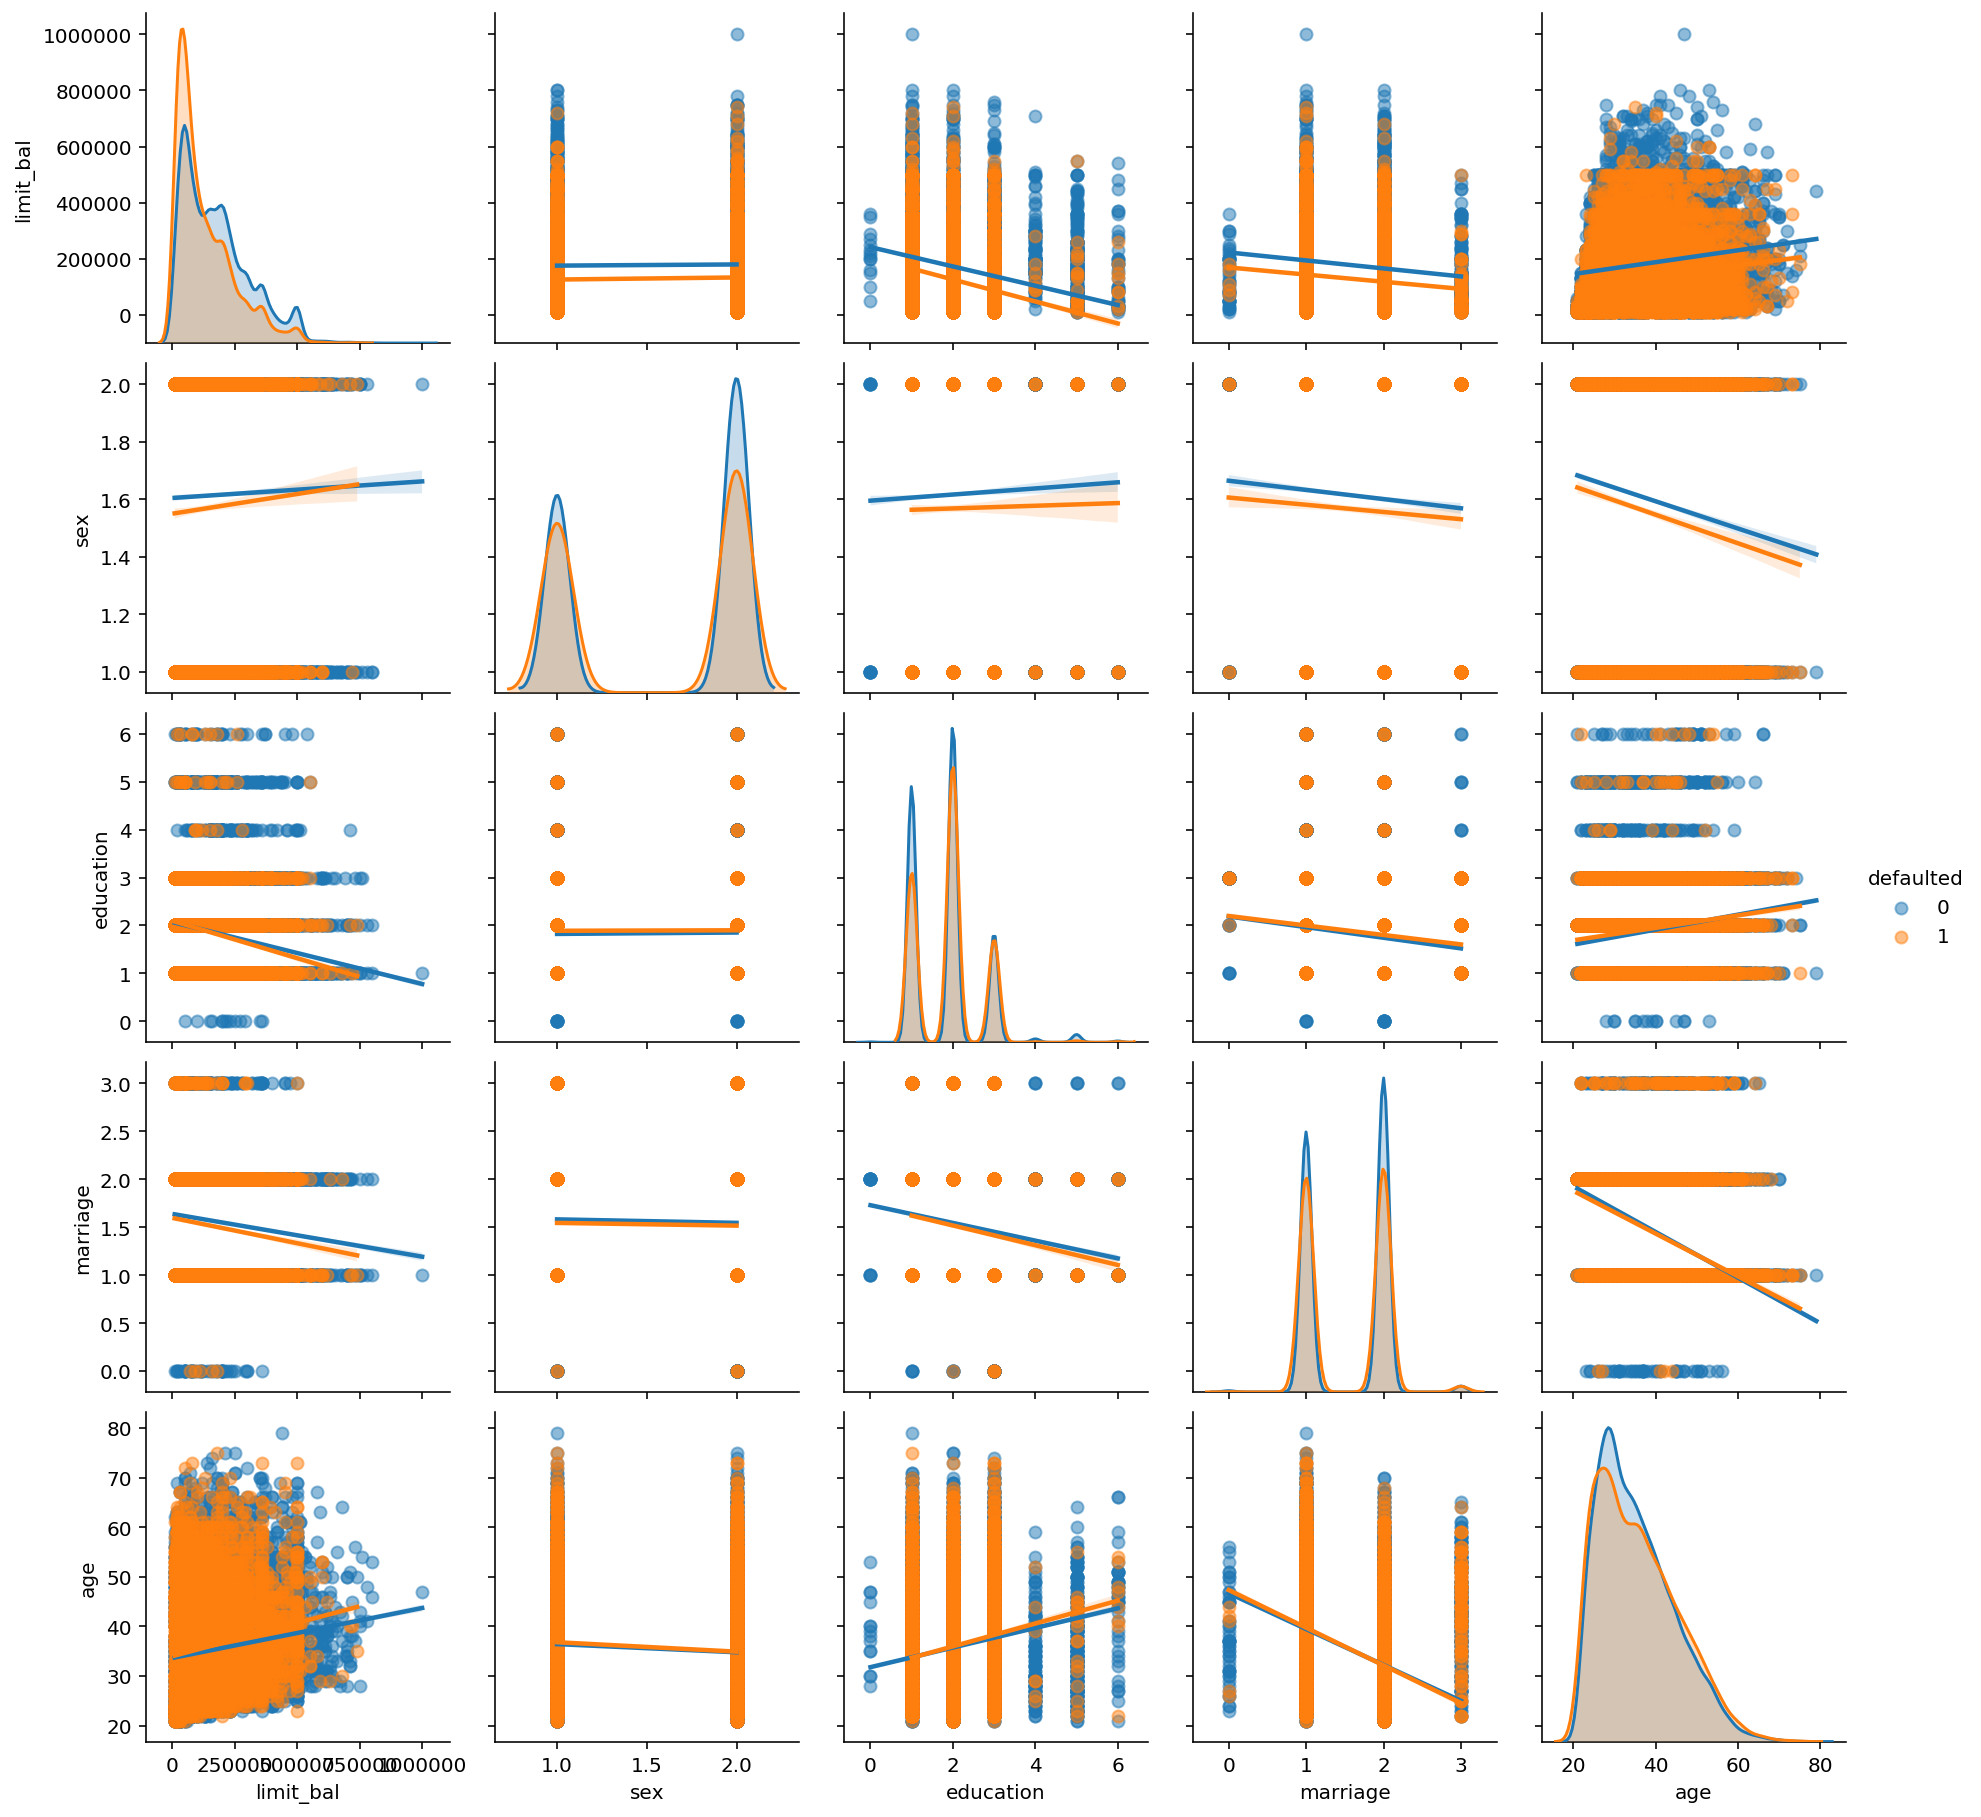

In [14]:
sns.pairplot(df_data, kind='reg', hue="defaulted", vars=['limit_bal', 'sex', 'education', 'marriage', 'age'], plot_kws={'scatter_kws': {'alpha': 0.5}})

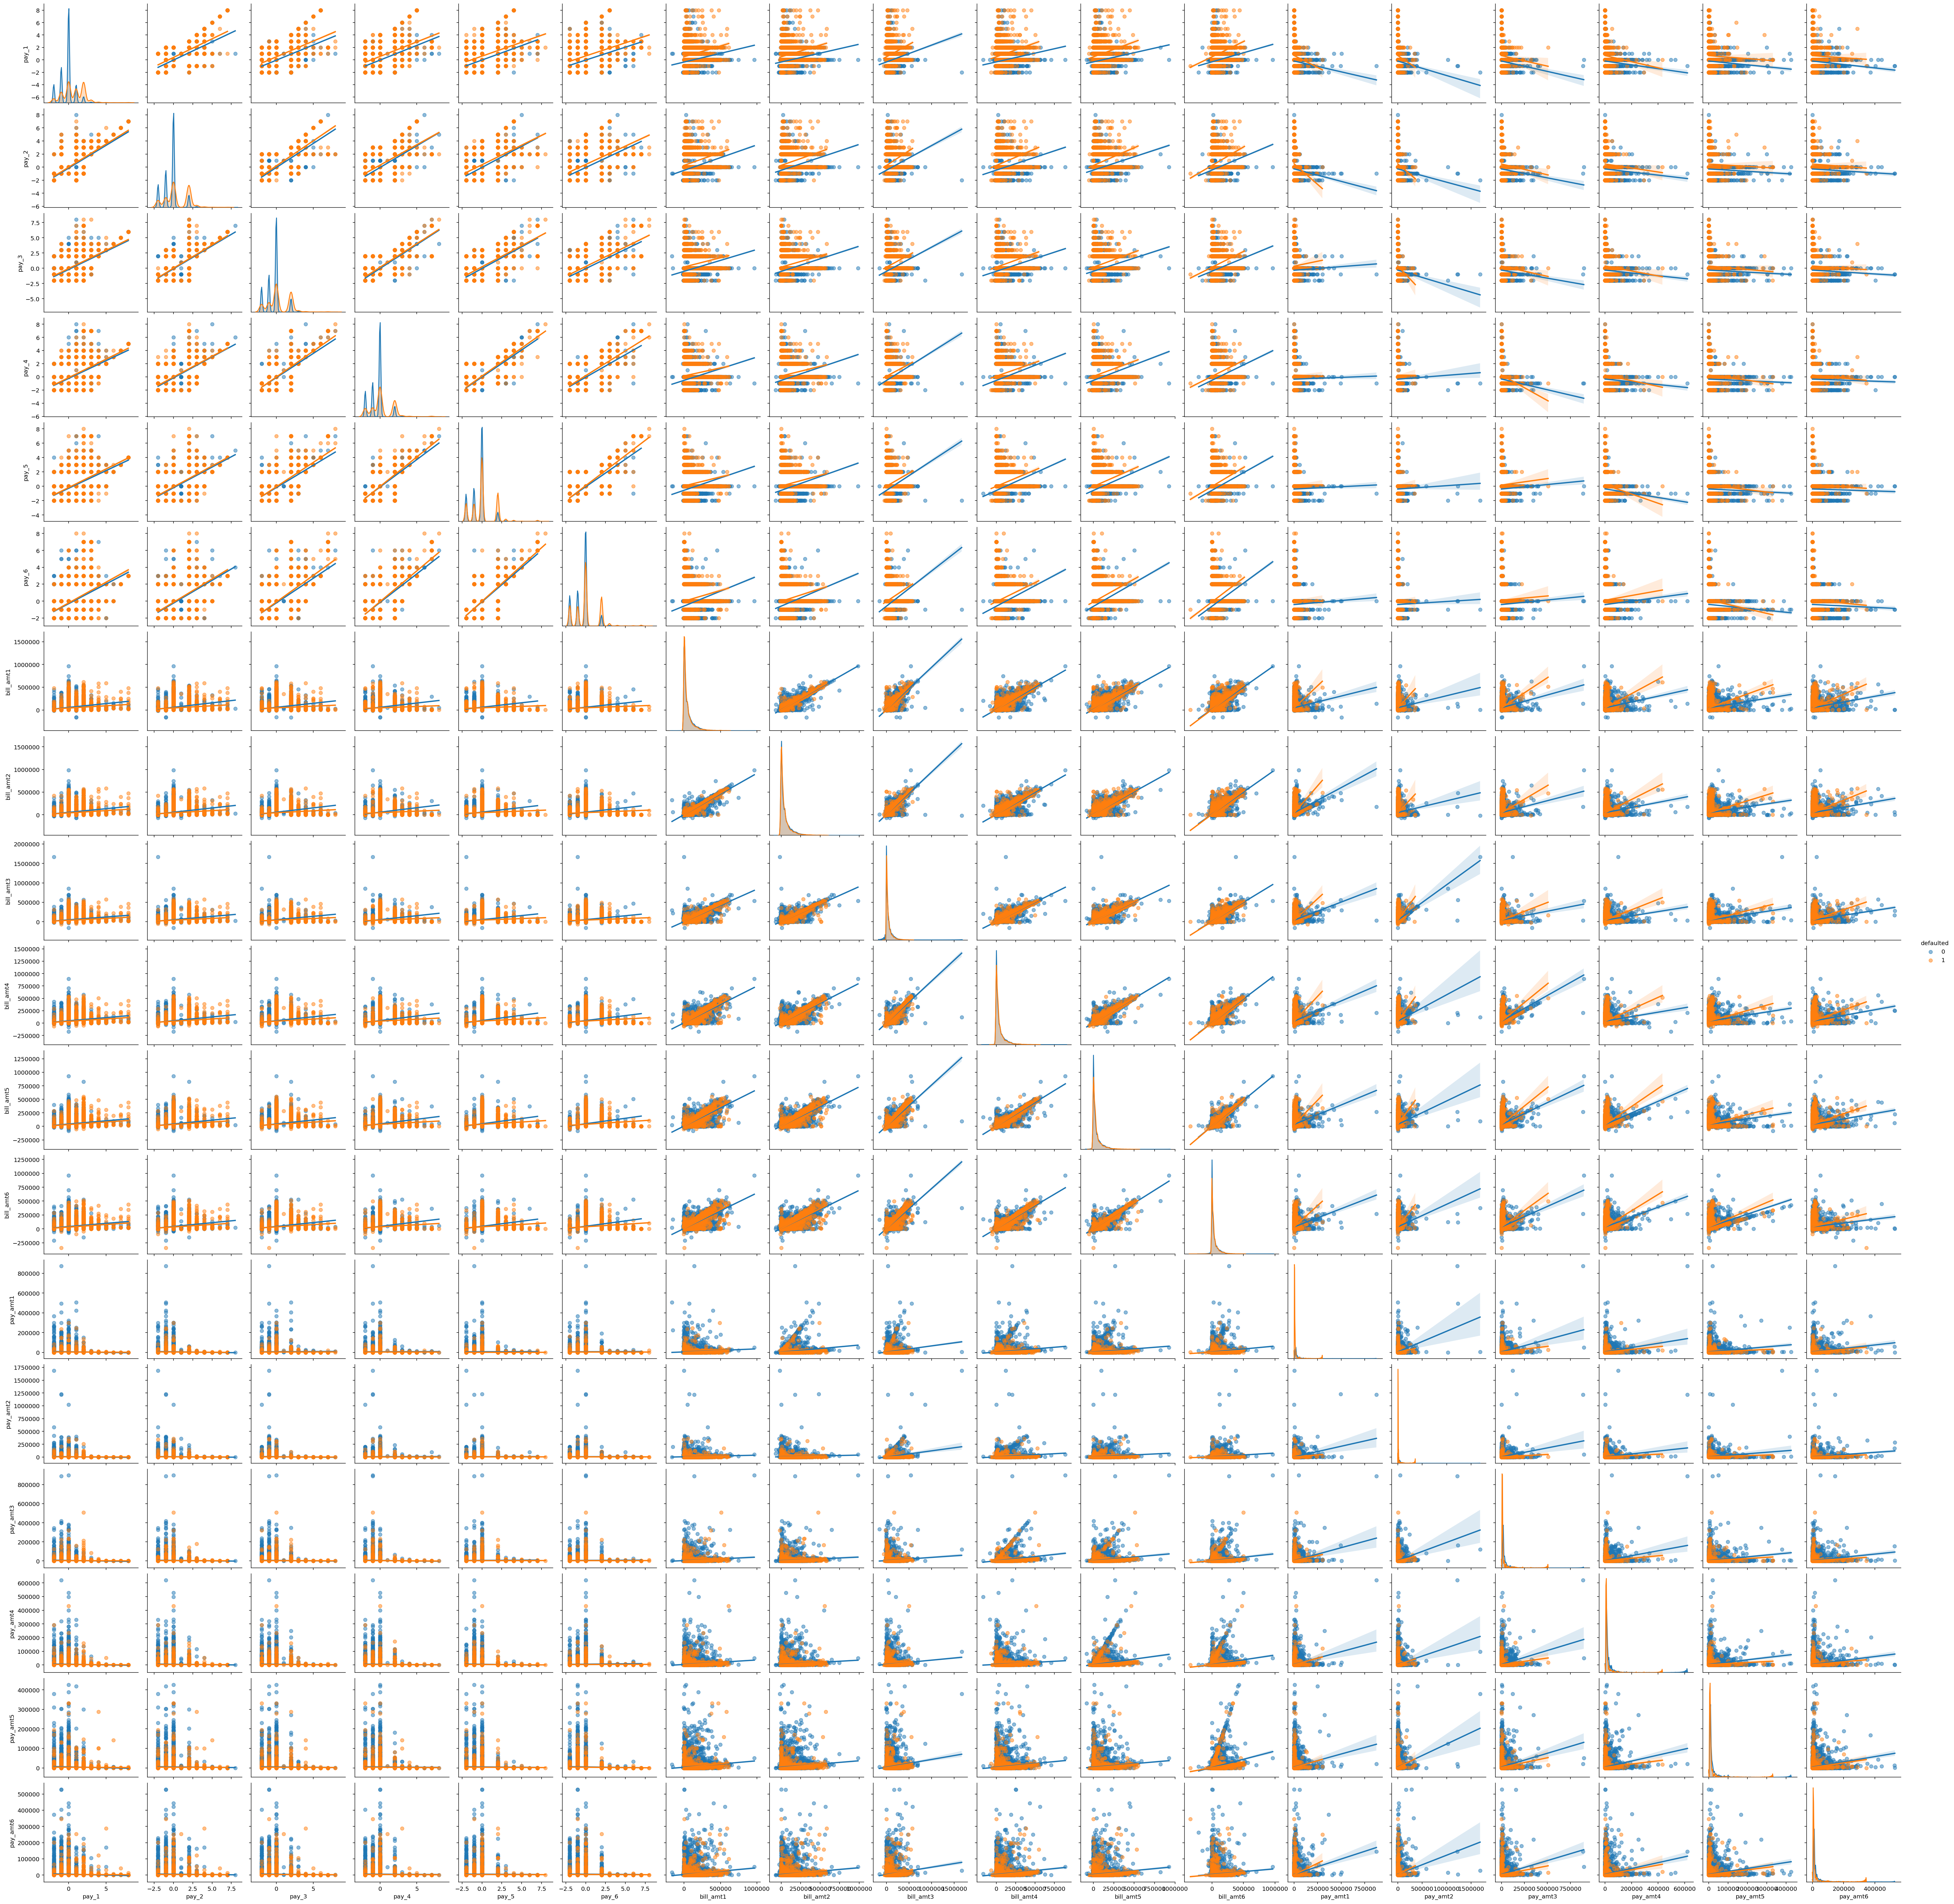

In [15]:
sns.pairplot(df_data, kind='reg', hue="defaulted", vars=['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 
                                 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
                                       'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'], 
             plot_kws={'scatter_kws': {'alpha': 0.5}})

> We can observe similar trend across all the following pairwise features __History of past payment`pay`__, __Amount of bill statement `bill_amt`__ and __Amount of previous statement`pay_mat`__. This is indication that we could easily implement a __Principal component analysis (PCA)__ as a dimensionality-reduction technique and discover the variance-covariance structure of a set of variables through linear combinations. 
A PCA will help us _improve algorithm Performance, reduce overfitting and in visualization and understanding the data in high dimensions._ However, caution needs to be taken as in reducing the dimentionality too much might result in _independent variables becomeingless interpretable and thus information loss. Moreover, we must standardize our data before implementing PCA, otherwise PCA will not be able to find the optimal Principal Components._


<a id='mime'></a>
## Models Implementation & Metrics Evaluation
<a id='dp'></a>
### Data Pre-Processing
We need to prepare our the data in the correct input format for the sklearn models considered. As such, we split our data into independent and dependent(terget) attributes and further into training and test subsets. The `subsets` tuble below will consists of four variables in the following order:
* __x_train:__ subset of independent variables used for training(`.fit`)
* __x_test:__ subset of independent variables used for testing(`.predict`)
* __y_train:__ subset of dependent(target) variables used for training(`.fit`)
* __y_test:__ subset of true variables used for comaprison against predicted values on `x_test`

In [16]:
# Split independent and target features 
independ_attrs, target_attrs = helpers.independ_target_attr_split(df_data)

# Split train and test data subsets
subsets = train_test_split(independ_attrs, target_attrs, test_size=0.1, random_state=1)

<a id='ms'></a>
### Model Selection

Now we do some investigation based-off of two of the most popular methods used in machine learning that can be differentiated by their methology in analysis that is **(lazy and eager learning)**. __This will help us give an idea of how other models in the same category might behave.
*  **K-Nearest Neighbor method(KNNs)** are the most popular _lazy algorithm_. The idea is to build a classification model once the test instance is received and this model will only learn a selection of training patterns, the most relevant for the test instance. When the query instance is received, a set of similar related patterns is retrieved from the available training patterns set and it is used to classify the new instance. To select these similar patterns, a distance measure is used having nearby points higher relevance. Lazy methods generally work by selecting the k nearest input patterns to the query points, in terms of the Euclidean distance. Afterwards, the classification or prediction of the new instances is based on the selected patterns.


* **Logistic Regression:** Most machine learning algorithms are _eager methods_ in the sense that a model is generated with the complete training data set and, afterwards, this model is used to generalize the new test instances. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable. Although many more complex extensions exist, it is one of the most situable approach to binary classification in financial services.

<a id='knn'></a>
#### K Nearest Neighbors(KNN) Model
After a series of trial and errors, the following choice of hyper parameters seem to give the best possible results.
* __n_neighbors:__ Our model produced the best results when we considered its 7 nearest neigbors. Other values seem to decrease our metrics.
* __threshold:__ The good thing about KNN is that it returns probability of defaulting for the test data `x_test`. However, this doesn't provide us situable data to evaluate our metrics, so we include a `threshold` parameter of defaulting in our model. The idea here is simple, any client with a probablity of defaulting above the threshold will default and vice versa. On our pericular data set the best results where obtianed at a probablity of 0.35.

In [17]:
# time on
knn_start = timeit.default_timer()

# Classifier
knn_pred, knn_true = knn.classifier(
    subsets=subsets, 
    n_neighbors = 7, 
    threshold = 0.35)

# time off
knn_stop = timeit.default_timer()
knn_time = knn_stop - knn_start

Our KNN analysis completed in 1.03s with the following scores...

accuracy_score  : 0.7160
precision_score : 0.3634
recall_score    : 0.3462
f1_score        : 0.3545


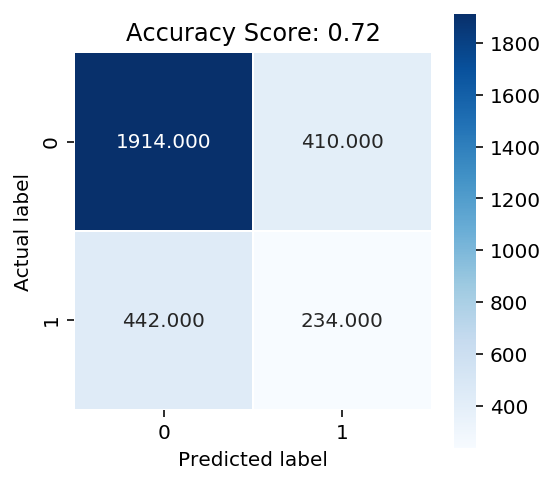

In [18]:
# Metrics
print("Our KNN analysis completed in {:.2f}s with the following scores...\n".format(knn_time))
print("accuracy_score  : {:.4f}".format(metrics.accuracy_score(knn_true, knn_pred)))
print("precision_score : {:.4f}".format(metrics.precision_score(knn_true, knn_pred)))
print("recall_score    : {:.4f}".format(metrics.recall_score(knn_true, knn_pred)))
print("f1_score        : {:.4f}".format(metrics.f1_score(knn_true, knn_pred)))

helpers.confusion_matrix(true=knn_true, pred=knn_pred)

<a id='lg'></a>
#### Logistic Regression Model
* __tolerance`tol`__: The tolerance value of 0.000014 seem to produce the best results before our training ovefits.
* __solver:__ The ‘liblinear’ is used here because it is more appropriate for a small data set of this size and it also supports both L1 and L2 regularization. Other solvers{‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’} didn't have enough data to train and converge and some of them handle either L1 or L2 regularization. 

In [19]:
# time on
lg_start = timeit.default_timer()

# Classifier
lg_pred, lg_true = logreg.classifier(
    tol=0.000014,
    subsets=subsets, 
    data=df_data,
    solver='liblinear')

lg_stop = timeit.default_timer()
lg_time = lg_stop - lg_start

Our logistic regression analysis completed in 5.37s with the following scores...

accuracy_score  : 0.8010
precision_score : 0.6890
recall_score    : 0.2130
f1_score        : 0.3254


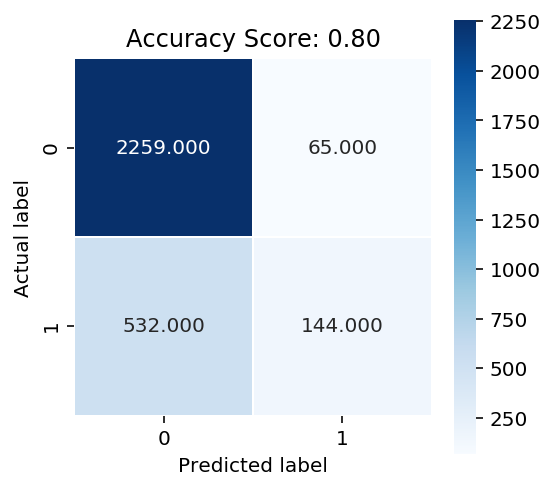

In [20]:
# Metrics
print("Our logistic regression analysis completed in {:.2f}s with the following scores...\n".format(lg_time))
print("accuracy_score  : {:.4f}".format(metrics.accuracy_score(lg_true, lg_pred)))
print("precision_score : {:.4f}".format(metrics.precision_score(lg_true, lg_pred)))
print("recall_score    : {:.4f}".format(metrics.recall_score(lg_true, lg_pred)))
print("f1_score        : {:.4f}".format(metrics.f1_score(lg_true, lg_pred)))

helpers.confusion_matrix(true=lg_true, pred=lg_pred)

<a id='ob'></a>
## Observations
* __Time:__ As expected, due to their differences in processing methologies, the time taken by the logistic regression(logreg) model takes is greater than the KNN. Precisely, the logreg model took 6 more times then the knn. This factor is especially important if we intend to depoy models locally. Of course there are other techniques to improve the perfermance of this by deploying pre-trained models instead.


* __Accuracy Score:__ Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when we have symmetric datasets where values of false positive and false negatives are almost same. Therefore, we have to look at other parameters to evaluate the performance of your model. For our model, we have got 0.803 which means our model is approx. 79.89% accurate.


* __Precision Score:__ Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all clients that labeled as defaulted, how many actually defaulted? High precision relates to the low false positive rate. We have got 66.9% precision which is pretty good.


* __Recall Score(Sensitivity):__ Recall is the ratio of correctly predicted positive observations to the all observations in actual class - 'defaulted'. The question recall answers is: Of all the clients that truly defaulted, how many did we label? We have got recall of 0.31 which is not good for this model as it’s below 0.5.


* __F1 Score:__ F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost.  In our case, F1 score is 0.31, as such there is room for improvement.

<a id='fi'></a>
## Further Improvements

To further improve our model, we could also consider using the Weight of Evidence(WoE) method which can help us have more control over the features we use during training. WoE consists of two steps:

1. **to split (a continuous) variable into few categories or to group (a discrete) variable into few categories (and in both cases you assume that all observations in one category have "same" effect on dependent variable)**
2. **to calculate WoE value for each category (then the original x values are replaced by the WoE values)**

The WoE transformation has the following advanatges:
* It can transform an independent variable so that it establishes monotonic relationship to the dependent variable. Actually it does more than this - to secure monotonic relationship it would be enough to "recode" it to any ordered measure (for example 1,2,3,4...) but the WoE transformation actually orders the categories on a "logistic" scale which is natural for logistic regression
* For variables with too many (sparsely populated) discrete values, these can be grouped into categories (densely populated) and the WoE can be used to express information for the whole category
* The (univariate) effect of each category on dependent variable can be simply compared across categories and across variables because WoE is standardized value (for example you can compare WoE of married people to WoE of manual workers)

Nonetheless, caution needs to be taken when implementing WoE since this methos also has some drawbacks:
* Loss of information (variation) due to binning to few categories
* It is a "univariate" measure so it does not take into account correlation between independent variables
* It is easy to manipulate (overfit) the effect of variables according to how categories are created